In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import sklearn.metrics as metrics

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import glob
import random
import os

Mounted at /content/gdrive


In [3]:
os.chdir("/content/gdrive/MyDrive/sensing_project/dataset")
print(os.getcwd())

/content/gdrive/.shortcut-targets-by-id/1tIm6FE4PVKLMw2Hcrr_Tfq1Ex0vrfmgo/sensing_project/dataset


In [4]:
img_filepaths = []
img_filepaths=(glob.glob("*/*[JPG,jpg]"))
print(len(img_filepaths))
print(img_filepaths)

540
['one/one_044.jpg', 'one/one_030.jpg', 'one/one_039.jpg', 'one/one_033.jpg', 'one/one_031.jpg', 'one/one_040.jpg', 'one/one_038.jpg', 'one/one_035.jpg', 'one/one_037.jpg', 'one/one_032.jpg', 'one/one_034.jpg', 'one/one_036.jpg', 'one/one_041.jpg', 'one/one_042.jpg', 'one/one_043.jpg', 'one/one_029.jpg', 'one/one_015.jpg', 'one/one_025.jpg', 'one/one_019.jpg', 'one/one_020.jpg', 'one/one_022.jpg', 'one/one_026.jpg', 'one/one_027.jpg', 'one/one_023.jpg', 'one/one_024.jpg', 'one/one_021.jpg', 'one/one_018.jpg', 'one/one_017.jpg', 'one/one_028.jpg', 'one/one_016.jpg', 'one/one_000.JPG', 'one/one_001.JPG', 'one/one_002.JPG', 'one/one_003.JPG', 'one/one_004.JPG', 'one/one_005.JPG', 'one/one_006.JPG', 'one/one_007.JPG', 'one/one_008.JPG', 'one/one_009.JPG', 'one/one_010.JPG', 'one/one_011.JPG', 'one/one_012.JPG', 'one/one_013.JPG', 'one/one_014.JPG', 'one/one_050.JPG', 'one/one_055.JPG', 'one/one_048.JPG', 'one/one_046.JPG', 'one/one_045.JPG', 'one/one_058.JPG', 'one/one_059.JPG', 'one/on

In [5]:
random.shuffle(img_filepaths)

In [6]:

def preprocess(image):
  image = cv2.resize(image,(224,224))
  image = image.astype("float32")
  return image

In [7]:
#get labels
labels = []
images = []
for file in img_filepaths:
  #处理图片
  img = cv2.imread(file)
  img = preprocess(img)
  images.append(img)

  #得到标签
  label = file.split("_")[0]
  label = label.split("/")[1]
  labels.append(label)

print(len(labels))
print(np.array(images).shape)

540
(540, 224, 224, 3)


In [8]:
#对labels进行处理，onehotencoder
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
values = array(labels)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

['fist' 'thumbleft' 'thumbright' 'gunup' 'thumbup' 'five' 'one'
 'thumbdown' 'thumbleft' 'thumbdown' 'thumbright' 'thumbright' 'gunup'
 'five' 'gundown' 'thumbdown' 'thumbleft' 'thumbup' 'thumbleft'
 'thumbright' 'thumbup' 'thumbup' 'thumbdown' 'gundown' 'five' 'fist'
 'five' 'thumbleft' 'thumbright' 'gunup' 'thumbup' 'five' 'five' 'gundown'
 'thumbdown' 'one' 'thumbup' 'fist' 'thumbdown' 'thumbright' 'gundown'
 'fist' 'five' 'one' 'thumbup' 'five' 'one' 'fist' 'one' 'gunup' 'thumbup'
 'thumbdown' 'gunup' 'one' 'gunup' 'fist' 'fist' 'five' 'thumbup'
 'thumbleft' 'one' 'thumbdown' 'thumbleft' 'fist' 'thumbup' 'gunup' 'five'
 'thumbleft' 'thumbright' 'thumbup' 'one' 'gundown' 'thumbdown' 'thumbup'
 'thumbleft' 'thumbdown' 'thumbdown' 'one' 'thumbleft' 'one' 'gundown'
 'one' 'one' 'gundown' 'thumbright' 'thumbup' 'thumbright' 'fist'
 'thumbdown' 'thumbup' 'thumbleft' 'gunup' 'five' 'fist' 'thumbdown'
 'five' 'thumbup' 'thumbup' 'thumbright' 'thumbright' 'gundown'
 'thumbdown' 'one' 'gundo

In [9]:
#for load weights
# optmz = SGD(lr=1e-4,
#       momentum=0.9,
#       decay=1e-4/25)
base = ResNet50(weights=None,
include_top=False,
input_tensor=Input(shape=(224, 224, 3)))

def createModel():
  h   = base.output
  h   = AveragePooling2D(pool_size=(5, 5))(h)
  h   = Flatten(name="flatten")(h)
  h   = Dense(128, activation="relu")(h)
  h   = Dropout(0.5)(h)
  h   = Dense(14, activation="softmax")(h)
  model = Model(inputs=base.input, outputs=h)
  for layer in base.layers:
    layer.trainable     = False
  model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])
  return model
model = createModel()


In [10]:
w = model.load_weights("/content/gdrive/MyDrive/sensing_project/model/sensing2.hdf5")

new_model = Model(inputs=model.input, outputs=model.get_layer('flatten').output)

In [12]:
#data split
(trdat,testdat,trlabel,testlabel)= train_test_split(np.array(images),np.array(onehot_encoded),test_size=0.25,stratify=np.array(onehot_encoded),random_state=0)


In [11]:
# optmz = SGD(lr=1e-4,
#       momentum=0.9,
#       decay=1e-4/25)
# base = ResNet50(weights=w,
# include_top=False,
# input_tensor=Input(shape=(224, 224, 3)))

def createModel1():
  h   = new_model.output
  # h   = AveragePooling2D(pool_size=(5, 5))(h)
  # h   = Flatten(name="flatten")(h)
  # # h   = Dense(512, activation="relu")(h)
  h   = Dense(128, activation="relu")(h)
  h   = Dropout(0.5)(h)
  h   = Dense(9, activation="softmax")(h)
  model = Model(inputs=new_model.input, outputs=h)
  for layer in new_model.layers:
    layer.trainable     = False
  model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])
  return model
model1 = createModel1()
# model1.summary()
modelgo1 = createModel1()#for testing


In [13]:
modelname = 'sensingbased1'
folderpath      = '/content/gdrive/My Drive/sensing_project/model/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_loss', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='min')
csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]

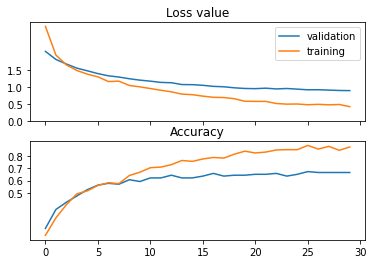

In [62]:
import pandas as pd
records     = pd.read_csv(folderpath+modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

In [14]:
mtest =model1.fit(trdat,trlabel, validation_data=(testdat,testlabel), batch_size=5,epochs=50, verbose=1, shuffle=True,callbacks=callbacks_list)

Epoch 1/50
81/81 [==============================] - 90s 1s/step - loss: 2.3133 - accuracy: 0.2889 - val_loss: 1.5406 - val_accuracy: 0.4963


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
81/81 [==============================] - 87s 1s/step - loss: 1.4874 - accuracy: 0.4864 - val_loss: 1.2418 - val_accuracy: 0.5259
Epoch 3/50
81/81 [==============================] - 86s 1s/step - loss: 1.1904 - accuracy: 0.5753 - val_loss: 0.9370 - val_accuracy: 0.6667
Epoch 4/50
81/81 [==============================] - 86s 1s/step - loss: 0.9416 - accuracy: 0.6617 - val_loss: 0.8613 - val_accuracy: 0.6889
Epoch 5/50
81/81 [==============================] - 86s 1s/step - loss: 0.8467 - accuracy: 0.6815 - val_loss: 0.8162 - val_accuracy: 0.7037
Epoch 6/50
81/81 [==============================] - 86s 1s/step - loss: 0.7209 - accuracy: 0.7407 - val_loss: 0.7353 - val_accuracy: 0.7333
Epoch 7/50
81/81 [==============================] - 89s 1s/step - loss: 0.5983 - accuracy: 0.7704 - val_loss: 0.7906 - val_accuracy: 0.6741
Epoch 8/50
81/81 [==============================] - 86s 1s/step - loss: 0.6232 - accuracy: 0.7802 - val_loss: 0.7977 - val_accuracy: 0.7037
Epoch 9/50
81/81 [==

In [109]:
modelgo.load_weights(filepath)
modelgo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

testimg = cv2.imread("/content/gdrive/MyDrive/sensing_project/dataset/test_data/6.jpg")
testimg = preprocess(testimg)
img = testimg.reshape(1,224,224,3)

# predicts = np.argmax(modelgo.predict(img),axis=1)
predicts = modelgo.predict(img)
print(predicts)
inverted = label_encoder.inverse_transform([argmax(predicts)])
print(inverted)


[[0.00701988 0.00310049 0.0079049  0.03888008 0.6264421  0.0095545
  0.01421032 0.00929854 0.28358927]]
['one']


In [ ]:
def takephoto():